# Visualization using Pandas and Matplotlib

The most important step in this notebook is Data Wrangling to represent data in required format containing only relevant data to visualize.

The objective of data wrangling is to clean (pre process), structure (change to required table format), and enrichen raw data (selection, and aggregation).

After wrangling, data is visualized as standard plots (bar, pie, histogram) using Pandas and Matplotlib

In [1]:
import numpy as np
import pandas as pd
import calendar
import datetime

import matplotlib.pyplot as plt

## Represent the data in wide format

In [2]:
df = pd.read_csv('/content/NYPD_Shooting.csv')
df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,244608249,05/05/2022,00:10:00,MANHATTAN,INSIDE,14,0.0,COMMERCIAL,VIDEO STORE,True,...,M,BLACK,25-44,M,BLACK,986050.000,214231.000000,40.754692,-73.993500,POINT (-73.9935 40.754692)
1,247542571,07/04/2022,22:20:00,BRONX,OUTSIDE,48,0.0,STREET,(null),True,...,(null),(null),18-24,M,BLACK,1016802.000,250581.000000,40.854402,-73.882330,POINT (-73.88233 40.854402)
2,84967535,05/27/2012,19:35:00,QUEENS,NaN,103,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1048632.000,198262.000000,40.710634,-73.767773,POINT (-73.76777349199995 40.71063412500007)
3,202853370,09/24/2019,21:00:00,BRONX,NaN,42,0.0,NaN,NaN,False,...,M,UNKNOWN,25-44,M,BLACK,1014493.000,242565.000000,40.832417,-73.890714,POINT (-73.89071440599997 40.832416753000075)
4,27078636,02/25/2007,21:00:00,BROOKLYN,NaN,83,0.0,NaN,NaN,False,...,M,BLACK,25-44,M,BLACK,1009149.375,190104.703125,40.688443,-73.910219,POINT (-73.91021857399994 40.68844345900004)


## Data Wrangling

### Pre processing

1. Drop columns adding little value
2. Replace null values

In [ ]:
df.columns

In [4]:
df = df.drop(
    labels=['INCIDENT_KEY', 'JURISDICTION_CODE', 'PERP_RACE', 'Lon_Lat',
            'PERP_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'PERP_AGE_GROUP'],
    axis=1)
df = df.replace(to_replace='(null)', value=np.nan)

### Enrichen raw data

1. Update timestamps with time of the day for example, 'Morning, Afternoon, Evening, Night'
2. Replace dates with months of the year
3. Transform the age column into a range

In [5]:
def get_month() -> list:
  """
  replace dates with the month of the year

  Return:
    months (list): name of the month assigned to the date
  """

  months = []

  for date in df['OCCUR_DATE']:
    month_num = int(date.split("/")[0])
    months.append(calendar.month_name[month_num])

  return months

def time_ofday() -> list:
  """
  replace timestamp with time of the day (Morning, Afternoon, Evening, etc.)

  Return:
    time (list): time of the day assigned to the timesamp
  """

  def time_in_range(start: datetime, end: datetime, current: datetime) -> bool:
    """Returns whether current is in the range [start, end]"""
    return start <= current <= end

  time = []
  time_dict = {
    "midnight": {
      "start": datetime.time(0, 0, 0),
      "end": datetime.time(3, 59, 59)
    },
    "early morning": {
      "start": datetime.time(4, 0, 0),
      "end": datetime.time(7, 59, 59)
    },
    "morning": {
      "start": datetime.time(8, 0, 0),
      "end": datetime.time(11, 59, 59)
    },
    "afternoon": {
      "start": datetime.time(12, 0, 0),
      "end": datetime.time(16, 59, 59)
    },
    "evening": {
      "start": datetime.time(17, 0, 0),
      "end": datetime.time(20, 59, 59)
    },
    "late evening": {
      "start": datetime.time(21, 0, 0),
      "end": datetime.time(23, 59, 59)
    }
  }
  
  for _, occur_time in enumerate(df['OCCUR_TIME']):
    for key, value in time_dict.items():
      if time_in_range(value.get("start"), value.get("end"), occur_time):
        time.append(key.title())

  return time

In [6]:
# convert occur_time to datetime object
df['OCCUR_TIME'] = pd.to_datetime(df['OCCUR_TIME'], format= '%H:%M:%S').dt.time
df['OCCUR_TIME'] = time_ofday()
df['OCCUR_DATE'] = get_month()

In [7]:
# victim age group modification
age_map = {
    '<18': '0-18',
    '18-24': '18-25',
    '25-44': '25-45',
    '45-64': '45-65',
    '65+': '65-100',
    'UNKNOWN': 'UNKNOWN'
}
df['VIC_AGE_GROUP'] = df['VIC_AGE_GROUP'].map(age_map)

In [8]:
df = df[df['VIC_AGE_GROUP'] != 'UNKNOWN']
df = df[df['VIC_RACE'] != 'UNKNOWN']
df = df[df['VIC_SEX'] != 'U']
df.head()

,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude
0,May,Midnight,MANHATTAN,INSIDE,14,COMMERCIAL,VIDEO STORE,True,25-45,M,BLACK,40.754692,-73.993500
1,July,Late Evening,BRONX,OUTSIDE,48,STREET,NaN,True,18-25,M,BLACK,40.854402,-73.882330
2,May,Evening,QUEENS,NaN,103,NaN,NaN,False,18-25,M,BLACK,40.710634,-73.767773
3,September,Late Evening,BRONX,NaN,42,NaN,NaN,False,25-45,M,BLACK,40.832417,-73.890714
4,February,Late Evening,BROOKLYN,NaN,83,NaN,NaN,False,25-45,M,BLACK,40.688443,-73.910219


## Plotting graphs

### Region wise analysis

- Bar plot depicting the number of shooting incidents in each region of New York City
- Pie plot representing the proportion of cases in each region to identify the most targtted region of NYC

<Axes: title={'center': 'Shooting cases in areas of NYC'}, xlabel='Region', ylabel='Reported cases'>

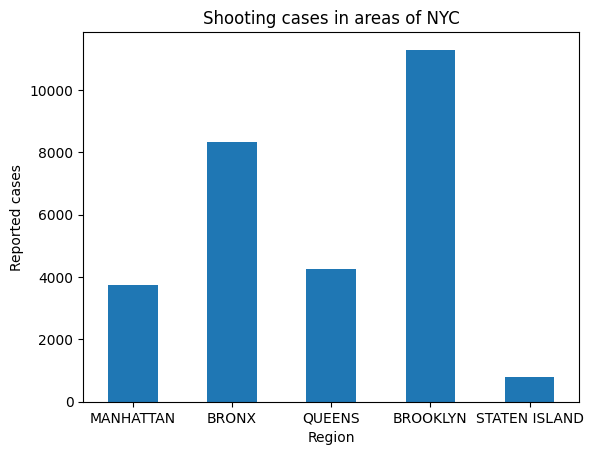

In [9]:
# region wise analysis of reported cases
areas = df['BORO'].value_counts(sort=False)
areas.plot.bar(
    xlabel = "Region",
    ylabel = "Reported cases",
    title = "Shooting cases in areas of NYC",
    rot=0
)

<Axes: title={'center': 'Proportion of shooting cases reported in each region of NYC'}, ylabel='count'>

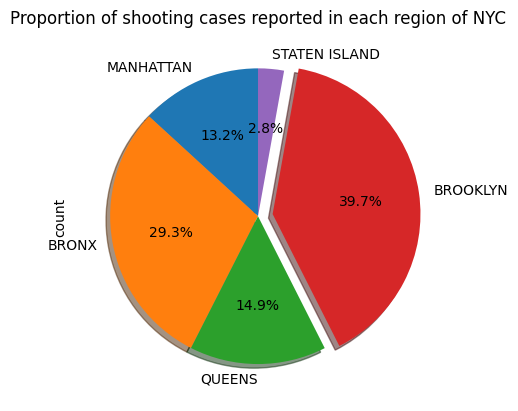

In [10]:
areas.plot.pie(
    title = "Proportion of shooting cases reported in each region of NYC",
    mark_right=False, legend = False,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    explode = (0, 0, 0, 0.1, 0)
)

### Trend in reported incidents 

- Line plot to represent the monthly and daily incidents reported

<Axes: title={'center': 'Trend in monthly shooting cases over 10 years'}, xlabel='Month', ylabel='Number of victims'>

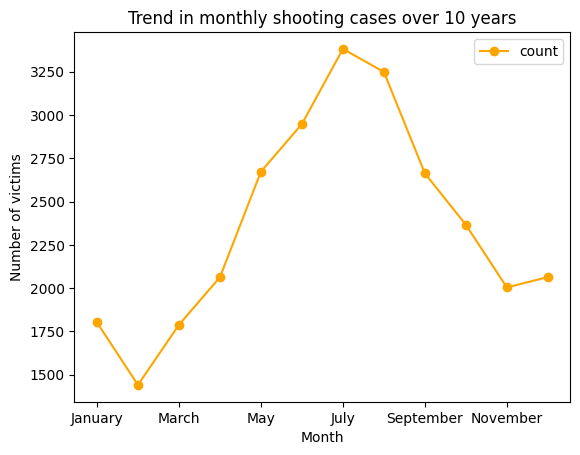

In [11]:
month_to_num = {
    'January': 1, 'February': 2, 'March': 3,
    'April': 4, 'May': 5, 'June': 6, 'July': 7,
    'August': 8, 'September': 9, 'October': 10,
    'November': 11, 'December': 12
}

month_dict = df['OCCUR_DATE'].value_counts(sort=False).to_dict()
month_data = {
    'months': [ele for ele in list(month_dict.keys())],
    'count': [ele for ele in list(month_dict.values())]
}
month_df = pd.DataFrame(month_data)
month_df['month_num'] = month_df['months'].map(month_to_num)
month_df = month_df.sort_values(by='month_num')
month_df = month_df.drop(labels=['month_num'], axis=1)
month_df.plot.line(
    x='months',
    y='count',
    xlabel='Month',
    ylabel='Number of victims',
    title='Trend in monthly shooting cases over 10 years',
    marker='o',
    color='orange'
)

<Axes: title={'center': 'Incident occurance time during the day over 10 years'}, xlabel='Time of the day', ylabel='Number of victims'>

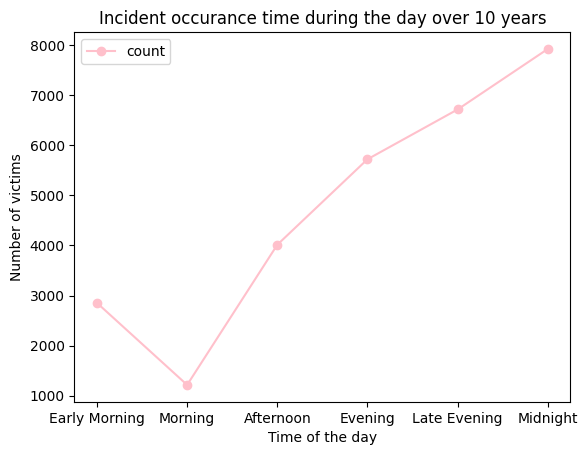

In [12]:
time_to_num = {
    'Early Morning': 1, 'Morning': 2, 'Afternoon': 3,
    'Evening': 4, 'Late Evening': 5, 'Midnight': 6
}

time_dict = df['OCCUR_TIME'].value_counts(sort=False).to_dict()
time_data = {
    'time': [ele for ele in list(time_dict.keys())],
    'count': [ele for ele in list(time_dict.values())]
}
time_df = pd.DataFrame(time_data)
time_df['time_num'] = time_df['time'].map(time_to_num)
time_df = time_df.sort_values(by='time_num')
time_df = time_df.drop(labels=['time_num'], axis=1)
time_df.plot.line(
    x='time',
    y='count',
    xlabel='Time of the day',
    ylabel='Number of victims',
    title='Incident occurance time during the day over 10 years',
    marker='o',
    color='pink'
)

### Age group analysis

- Bar plot to obtain the number of victims in age group
- Radial plot to compare each age group values and compare their ratios

In [13]:
age_to_num = {
    '0-18': 1, '18-25': 2, '25-45': 3,
    '45-65': 4, '65-100': 5
}
age_groups = df['VIC_AGE_GROUP'].value_counts(sort=False).to_dict()
age_data = {
    'age': [ele for ele in list(age_groups.keys())],
    'count': [ele for ele in list(age_groups.values())]
}
age_df = pd.DataFrame(age_data)
age_df['age_num'] = age_df['age'].map(age_to_num)
age_df = age_df.sort_values(by='age_num')
age_df = age_df.drop(labels=['age_num'], axis=1)
age_df.head()

,age,count
4,0-18,2950
1,18-25,10360
0,25-45,12952
2,45-65,1975
3,65-100,205


<Axes: title={'center': 'Age groups of shooting case victims'}, xlabel='Age group', ylabel='No. of victims'>

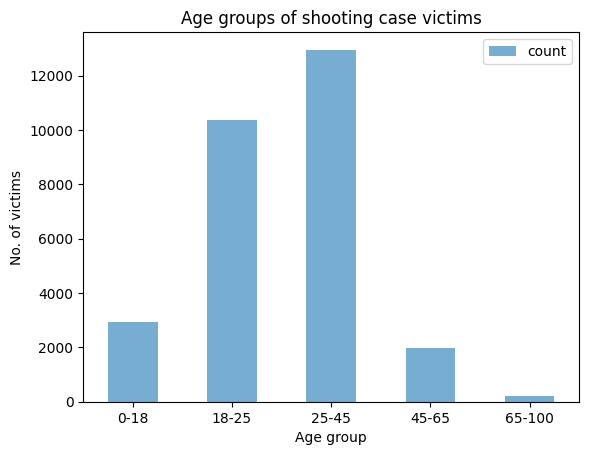

In [14]:
age_df.plot.bar(
    x='age',
    y='count',
    xlabel = 'Age group',
    ylabel = 'No. of victims',
    title = 'Age groups of shooting case victims',
    alpha=0.6,
    rot=0
)

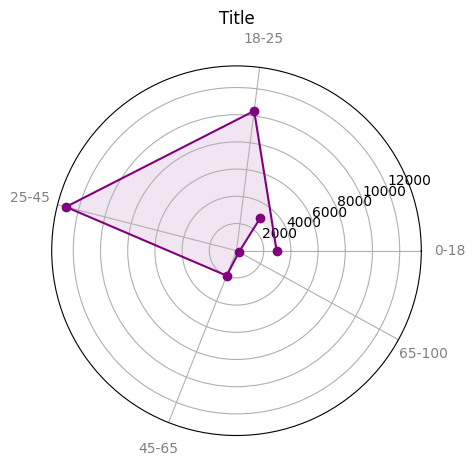

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

# theta has 5 different angles, and the first one repeated
theta = np.arange(len(age_df) + 1) / float(len(age_df)) * 2.3 * np.pi
# values has the 5 values from 'Col B', with the first element repeated
values = age_df['count'].values
values = np.append(values, values[0])
# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="purple", marker="o", label="count")
plt.xticks(ticks=theta[:-1], labels=age_df['age'], color='grey', size=10)
# to increase the distance of the labels to the plot
ax.tick_params(pad=10)
# fill the area of the polygon with green and some transparency
ax.fill(theta, values, 'purple', alpha=0.1)

# shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
# plt.legend()
plt.title("Title")
plt.show()

### Ethnicity analysis

- Donut plot to represent the proportion of each ethnicity

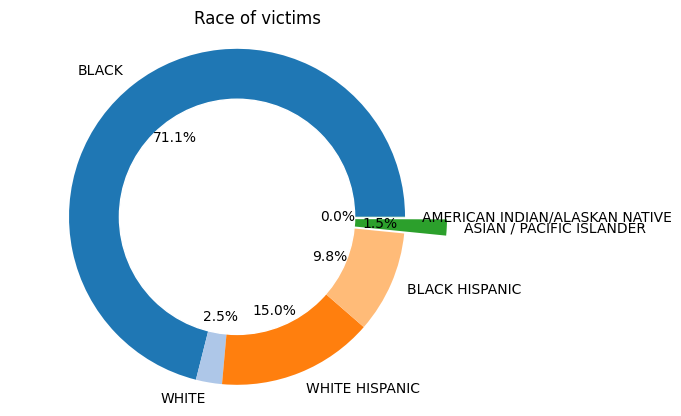

In [16]:
victim_race = df['VIC_RACE'].value_counts(sort=False).to_dict()
victim_race = {
    "race": [ele for ele in list(victim_race.keys())],
    "count": [ele for ele in list(victim_race.values())]
}
df_victim = pd.DataFrame(victim_race)
df_victim['Percentage'] = df_victim['count'] / df_victim['count'].sum() * 100

# Create the donut plot
fig, ax = plt.subplots()
ax.pie(
    df_victim['Percentage'], explode=(0, 0, 0, 0, 0.25, 0),
    labels=df_victim['race'], autopct='%1.1f%%',
    startangle=0, colors=plt.cm.tab20.colors
)
circle = plt.Circle((0, 0), 0.7, color='white')
fig.gca().add_artist(circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Add a title
plt.title('Race of victims')
# plt.xticks(ticks=np.arange(3), labels=df_victim['race'].tolist(), rotation=60)

plt.show()

### Incidents reported in each locality

Each region of NYC has well demarcated localities: commercial, dwelling, parking lot, playgroun, etc. The objective here is to compare the number of incidents reported in each of these localities in each region as a bar plot. To visualize the data as a bar plot, the data was wrangled as explained below:

1. **Enrich raw data**- aggregation of 'BORO' and 'LOC_CLASSFCTN_DESC' columns
2. **Structure the data**- represent the data as a pivot table indexed by 'BORO' and having 'LOC_CLASSFCTN_DESC' as the column values
3. **Selection**- drop the rows and columns that add little to no value

In [17]:
# aggregation
region_loca = df.groupby(by=['BORO', 'LOC_CLASSFCTN_DESC']).size()
# Pivot table
pivot_counts = df.pivot_table(
    index='BORO', columns='LOC_CLASSFCTN_DESC',
    aggfunc='size', fill_value=0
)
pivot_counts

LOC_CLASSFCTN_DESC,COMMERCIAL,DWELLING,HOUSING,OTHER,PARKING LOT,PLAYGROUND,STREET,TRANSIT,VEHICLE
BORO,,,,,,,,,
BRONX,56,65,116,11,4,6,702,4,9
BROOKLYN,75,99,193,24,4,12,552,12,7
MANHATTAN,42,18,105,10,2,15,298,3,3
QUEENS,31,46,41,10,5,7,288,4,9
STATEN ISLAND,3,14,5,4,0,1,43,0,1


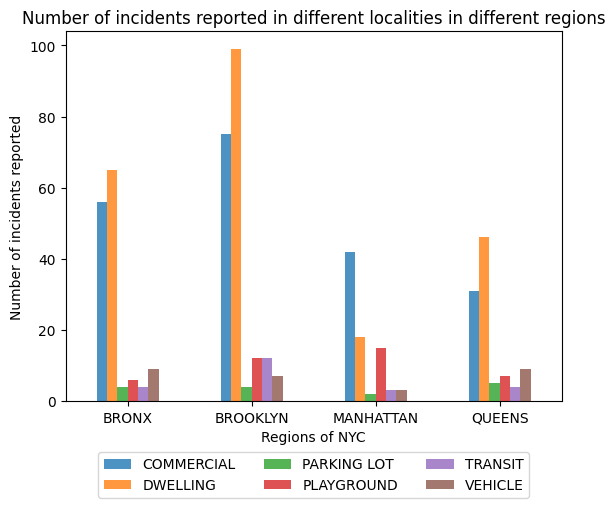

In [18]:
# selection
pivot_counts = pivot_counts.drop(['STREET', 'OTHER', 'HOUSING'], axis=1)
pivot_counts = pivot_counts.drop(['STATEN ISLAND'], axis=0)

# visualization
ax = pivot_counts.plot.bar(
    title = 'Number of incidents reported in different localities in different regions',
    xlabel = 'Regions of NYC',
    ylabel = 'Number of incidents reported',
    alpha = 0.8,
    rot=0
)
ax.legend(
    loc='center', 
    bbox_to_anchor=(0.5, -0.2), 
    ncol=3
)

### Gender wise representation of each age group

- Stacked bar plot representing the gender of each age group quantitatively

<Axes: title={'center': 'Gender wise representation of each age group'}, xlabel='Victim age group', ylabel='Number of victims'>

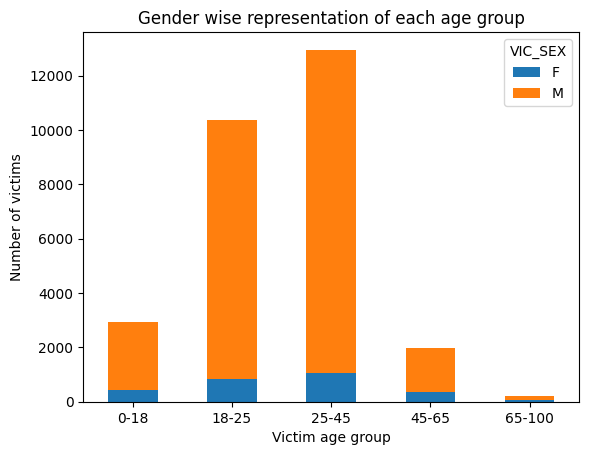

In [19]:
counts = df.groupby(['VIC_AGE_GROUP', 'VIC_SEX']).size().unstack(fill_value=0)
counts.plot.bar(
    stacked=True,
    xlabel = 'Victim age group',
    ylabel = 'Number of victims',
    title = 'Gender wise representation of each age group',
    rot=0
)

### Bonus plots

- Histogram of the 'PRECINCT' column

<Axes: title={'center': 'Plot of PRECINCT column values'}, xlabel='Numeric values of PRECINCT', ylabel='Frequency'>

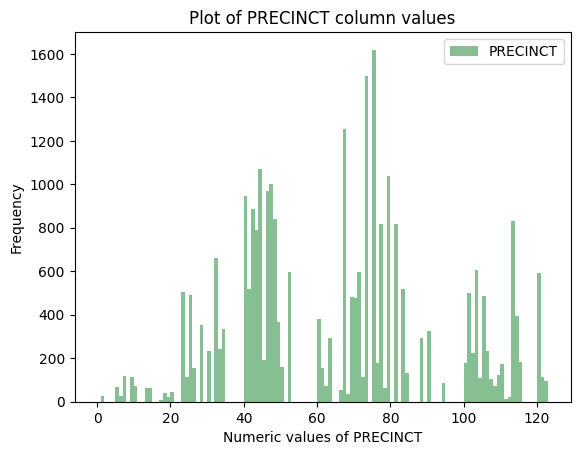

In [20]:
# histogram
df.plot.hist(
    column='PRECINCT',
    bins=range(0,max(df['PRECINCT'])+1),
    color='#86bf91',
    xlabel='Numeric values of PRECINCT',
    ylabel='Frequency',
    title = 'Plot of PRECINCT column values'
)

- **Nested Donut**: represent the relation between the classified localities and their descriptions after wrangling. This plot was later extended to a *Sankey diagram* in [Plotly]()

Data wrangling steps:
1. **Selection**- drop null values, and the rows and columns that add little to no value
2. **Enrich raw data**- aggregation of 'LOC_CLASSFCTN_DESC' and 'LOCATION_DESC' columns
3. **Structure the data**- represent the data as a pivot table indexed by 'LOC_CLASSFCTN_DESC' and having 'LOCATION_DESC' as the column values

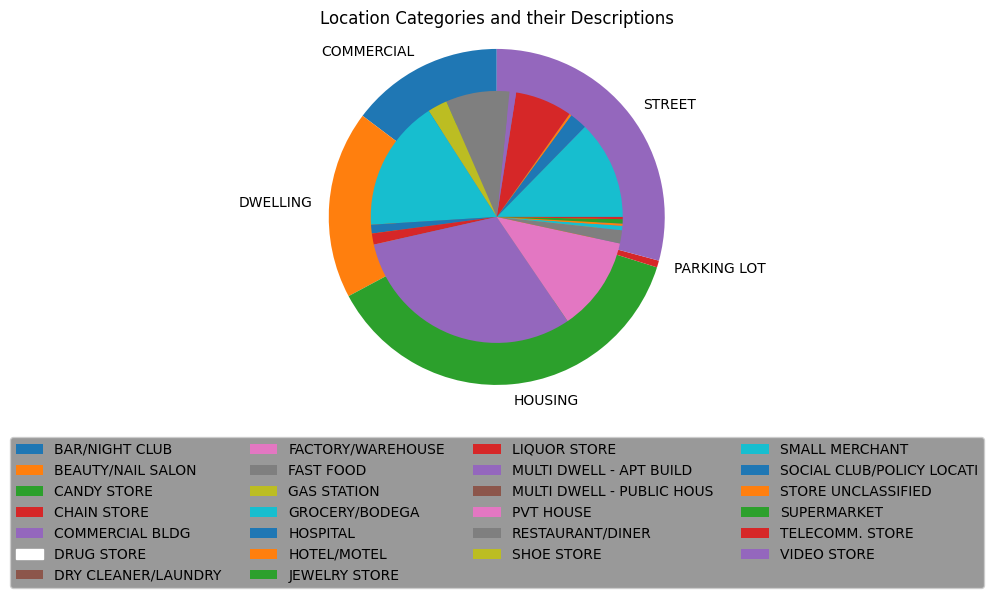

In [21]:
# selection
hierarchy = df[['LOC_CLASSFCTN_DESC', 'LOCATION_DESC']].dropna()
hierarchy = hierarchy[hierarchy['LOC_CLASSFCTN_DESC']!='OTHER']
# aggregation
grouped_counts = hierarchy.groupby(['LOC_CLASSFCTN_DESC', 'LOCATION_DESC']).size().reset_index(name='count')
# Pivot table
pivot_table = grouped_counts.pivot(index='LOC_CLASSFCTN_DESC', columns='LOCATION_DESC', values='count').fillna(0)

# Plot the nested pie chart
fig, ax = plt.subplots()
ax.pie(
    pivot_table.sum(axis=1), 
    labels=pivot_table.index, 
    startangle=90
)

# Draw a circle at the center of the pie to make it a donut chart
center_circle = plt.Circle((0, 0), 0.25, color='white')
ax.add_artist(center_circle)
# Calculate the total count for each LOC_CLASSFCTN_DESC
total_counts = pivot_table.sum(axis=1)
# Draw the nested pie chart
for i, (label, data) in enumerate(pivot_table.iterrows()):
    ax.pie(
        data, 
        radius=0.75*(i+1)/len(pivot_table), 
        startangle=0
    )
# Add a legend
plt.legend(
    pivot_table.columns, 
    loc='center',
    ncol=4, 
    bbox_to_anchor=(0.5, -0.3), 
    facecolor='grey'
)
# Set aspect ratio to be equal to ensure circular pie charts
plt.axis('equal')
# Title of the plot
plt.title('Location Categories and their Descriptions')

# Display the plot
plt.show()

### Visualization on a map

Scatter plot of the reported cases on a map to depict the hotspots in each region of NYC. The object of this section is to plot all the reported cases and indentify the safe zones. I have added the geographical coordinates of landmarks I would be visting in NYC and observe the hotspots nearby.

**Library used- GeoPandas**

References:
1. [GeoPandas on csv](https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6)
2. [Color choices](https://matplotlib.org/3.3.2/tutorials/colors/colors.html)

In [ ]:
# install dependency
!pip install geoplot

In [23]:
import geoplot

from shapely.geometry import Point
from geopandas import GeoDataFrame, read_file

In [24]:
# create dataframe
murder_df = df[df['STATISTICAL_MURDER_FLAG']][['BORO', 'Latitude', 'Longitude']].dropna()
murder_df

,BORO,Latitude,Longitude
0,MANHATTAN,40.754692,-73.993500
1,BRONX,40.854402,-73.882330
6,QUEENS,40.673306,-73.789887
9,BRONX,40.860463,-73.865561
11,QUEENS,40.769744,-73.909872
...,...,...,...
28544,BROOKLYN,40.634916,-73.932963
28549,QUEENS,40.700826,-73.881490
28551,BROOKLYN,40.695772,-73.979528
28557,BRONX,40.903785,-73.850098


In [26]:
# add coordinates of the places to vist
places = {
    "BORO": ["TIMES SQUARE", "EMPIRE STATE", "CENTRAL PARK", \
             "NYU", "COLUMBIA", "WALL STREET", "US OPEN (TENNIS)"],
    "Latitude": [40.758896, 40.748817, 40.785091, \
                 40.729675, 40.807384, 40.706005, 40.739716],
    "Longitude": [-73.985130, -73.985428, -73.968285, \
                  -73.996925, -73.963036, -74.008827, -73.840782]
}
places_df = pd.DataFrame(places)
places_df

,BORO,Latitude,Longitude
0,TIMES SQUARE,40.758896,-73.985130
1,EMPIRE STATE,40.748817,-73.985428
2,CENTRAL PARK,40.785091,-73.968285
3,NYU,40.729675,-73.996925
4,COLUMBIA,40.807384,-73.963036
5,WALL STREET,40.706005,-74.008827
6,US OPEN (TENNIS),40.739716,-73.840782


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


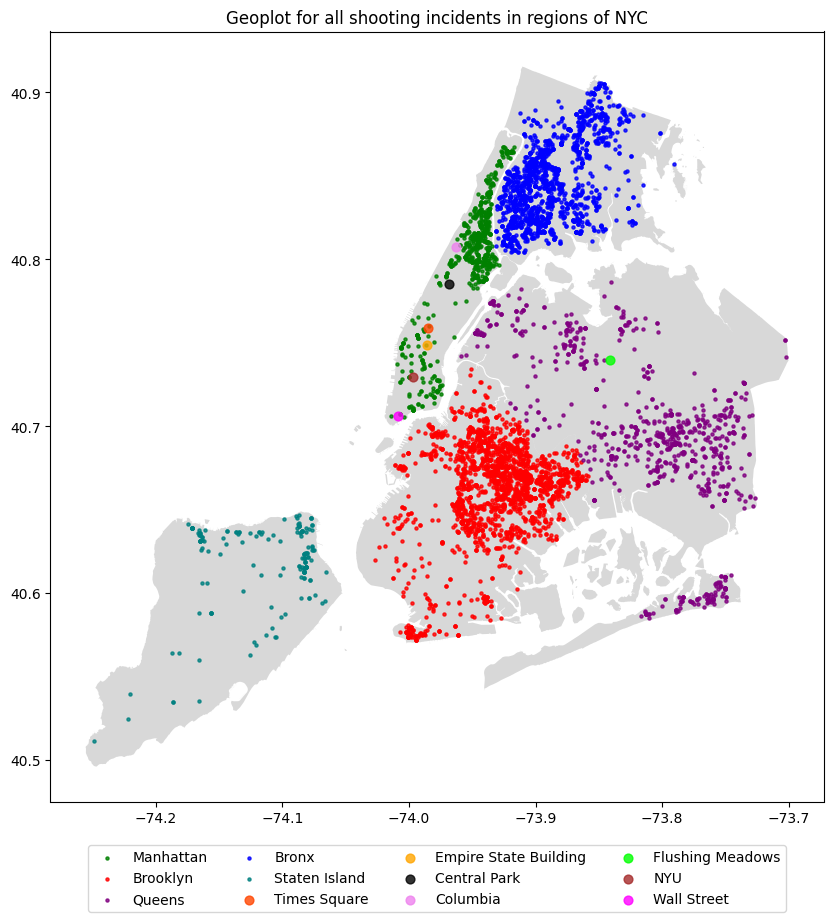

In [27]:
geometry = [Point(xy) for xy in zip(murder_df['Longitude'], murder_df['Latitude'])]
places_geometry = [Point(xy) for xy in zip(places_df['Longitude'], places_df['Latitude'])]
crs={'init':'epsg:4326'}
boroughs = read_file(geoplot.datasets.get_path('nyc_boroughs'))

# create geodatframe for the library
geo_df = GeoDataFrame(murder_df, crs=crs, geometry=geometry)
place_geo_df = GeoDataFrame(
    places_df, 
    crs=crs, 
    geometry=places_geometry
)

fig,ax=plt.subplots(figsize=(10,10))
boroughs.plot(ax=ax,alpha=0.3,color="grey")

# region wise scatter plot on the map
geo_df[geo_df['BORO']=="MANHATTAN"].plot(ax=ax,markersize=5, alpha=0.8,color="green", label="Manhattan")
geo_df[geo_df['BORO']=="BROOKLYN"].plot(ax=ax,markersize=5, alpha=0.8,color="red", label="Brooklyn")
geo_df[geo_df['BORO']=="QUEENS"].plot(ax=ax,markersize=5, alpha=0.8,color="purple", label="Queens")
geo_df[geo_df['BORO']=="BRONX"].plot(ax=ax,markersize=5, alpha=0.8,color="blue", label="Bronx")
geo_df[geo_df['BORO']=="STATEN ISLAND"].plot(ax=ax,markersize=5, alpha=0.8,color="teal", label="Staten Island")
# plot the places to visit on the map
place_geo_df[place_geo_df["BORO"] == "TIMES SQUARE"].plot(ax=ax, markersize=40, alpha=0.8,color="orangered", label="Times Square")
place_geo_df[place_geo_df["BORO"] == "EMPIRE STATE"].plot(ax=ax, markersize=40, alpha=0.8,color="orange", label="Empire State Building")
place_geo_df[place_geo_df["BORO"] == "CENTRAL PARK"].plot(ax=ax, markersize=40, alpha=0.8,color="black", label="Central Park")
place_geo_df[place_geo_df["BORO"] == "COLUMBIA"].plot(ax=ax, markersize=40, alpha=0.8,color="violet", label="Columbia")
place_geo_df[place_geo_df["BORO"] == "US OPEN (TENNIS)"].plot(ax=ax, markersize=40, alpha=0.8,color="lime", label="Flushing Meadows")
place_geo_df[place_geo_df["BORO"] == "NYU"].plot(ax=ax, markersize=40, alpha=0.8,color="brown", label="NYU")
place_geo_df[place_geo_df["BORO"] == "WALL STREET"].plot(ax=ax, markersize=40, alpha=0.8,color="magenta", label="Wall Street")

plt.title(label="Geoplot for all shooting incidents in regions of NYC", loc='center')
plt.legend(
    loc='center', 
    ncol=4, 
    bbox_to_anchor=(0.5, -0.1)
)